# Kaan Koseler - Rossmann Stores Challenge

## Goal
- Given 2 years of previous sales data for Rossmann Stores, predict six weeks of future sales.
- We are given a training file as .csv with store sales data, another .csv with extra information about each store, and a test .csv that will be used for submission.

## Approach
1. Load, check, and clean the data as necessary.
    - Read in files as Pandas DataFrames.
    - Impute missing values.
    - Convert categorical features to numerical representation.
    - Merge the training dataframe with store dataframe.
2. Data analysis & visualization
    - Examine average sales over various time steps (month, day, week, etc.)
    - Create boxplots to analyze sales by features.
    - Create scatterplots with correlations where appropriate.
    - Autocorrelation plots for each store type to determine 
    long and short-term effects of previous sales.
3. Build models
    - Train a standard neural network as a baseline.
    - Use a more powerful Gradient-Boosted Trees approach.
    - Create plots to chart performance on training/validation sets and determine potential overfitting.
4. Future Work
    - Speculate on possible future approaches.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Activation
import xgboost

C:\Users\Kaan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load and check data

In [2]:
df = pd.read_csv('train.csv')

df_test = pd.read_csv('test.csv')

C:\Users\Kaan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


#### Looks like we're working with training data from 01/01/2013 - 07/31/2015

In [5]:
df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

#### Let's do some feature engineering by extracting 'Date' into 4 separate columns, and converting the categorical 'StateHoliday' column to a numerical representation

In [6]:
le = LabelEncoder()

In [7]:
df['StateHoliday'] = df['StateHoliday'].astype(str)
df['Date'] = pd.to_datetime(df['Date'])

df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Week'] = df['Date'].dt.week

df['StateHoliday'] = le.fit_transform(df['StateHoliday'])

In [8]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [9]:
df_test.tail()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0
41087,41088,1115,6,2015-08-01,1.0,0,0,1


#### Looks like we're working with test data from 08/01/2015 - 09/17/2015

In [10]:
df_test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

#### We need to impute the open column for a very small number of observations. Let's assume the store is open as they're usually only closed on Sundays. We'll also do similar feature engineering here as we did for the training set.

In [11]:
df_test['Open'].fillna(1.0, inplace=True)

df_test['StateHoliday'] = df_test['StateHoliday'].astype(str)
df_test['Date'] = pd.to_datetime(df_test['Date'])

df_test['Day'] = df_test['Date'].dt.day
df_test['Month'] = df_test['Date'].dt.month
df_test['Year'] = df_test['Date'].dt.year
df_test['Week'] = df['Date'].dt.week

df_test['StateHoliday'] = le.fit_transform(df_test['StateHoliday'])

#### Load the 'store' dataset we've been provided that contains added information about each store.

In [12]:
df_store = pd.read_csv('store.csv')
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [13]:
df_store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

#### If I had more time, I would do some more with the final three columns regarding Promo2 info. For the case of this challenge I'll just use Promo2, and use Median values for 'Competition...' columns. There are many missing values, and as we'll see soon Promo2 has little correlation with Sales.

In [14]:
df_store.drop(['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], inplace=True, axis=1)
store_impute_dict = {'CompetitionDistance': df_store['CompetitionDistance'].median(),
                     'CompetitionOpenSinceMonth': df_store['CompetitionOpenSinceMonth'].median(),
                     'CompetitionOpenSinceYear': df_store['CompetitionOpenSinceYear'].median()}
df_store.fillna(store_impute_dict, inplace=True)

In [15]:
df_merged = pd.merge(df, df_store, how='inner', on='Store')
df_merged['StoreType'] = le.fit_transform(df_merged['StoreType'])
df_merged['Assortment'] = le.fit_transform(df_merged['Assortment'])

df_test_merged = pd.merge(df_test, df_store, how='inner', on='Store')
df_test_merged['StoreType'] = le.fit_transform(df_test_merged['StoreType'])
df_test_merged['Assortment'] = le.fit_transform(df_test_merged['Assortment'])

In [16]:
df_merged.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,Week,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
0,1,5,2015-07-31,5263,555,1,1,0,1,31,7,2015,31,2,0,1270.0,9.0,2008.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,30,7,2015,31,2,0,1270.0,9.0,2008.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,29,7,2015,31,2,0,1270.0,9.0,2008.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,28,7,2015,31,2,0,1270.0,9.0,2008.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,27,7,2015,31,2,0,1270.0,9.0,2008.0,0


In [35]:
# USE FOR ANALYSIS
df_open = df_merged[df_merged['Open'] == 1]

## Data Analysis & Visualization

In [17]:
sns.set_style('darkgrid')
def linePlot(data, xlabel, ylabel, title):
    plt.plot(data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

### Examine real-valued features

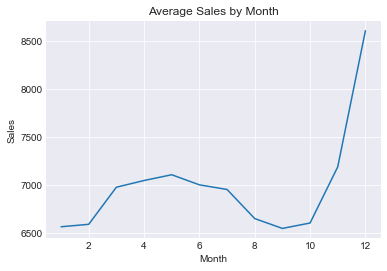

In [36]:
sales_per_month = df_open.groupby('Month')['Sales'].mean()
linePlot(sales_per_month, 'Month', 'Sales', 'Average Sales by Month')

#### Very high sales in December, makes sense as this is the holiday season.

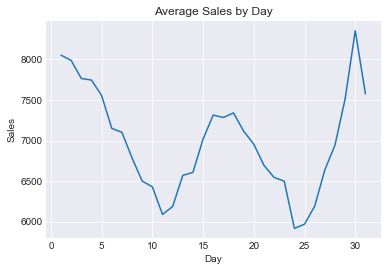

In [37]:
sales_per_day = df_open.groupby('Day')['Sales'].mean()
linePlot(sales_per_day, 'Day', 'Sales', 'Average Sales by Day')

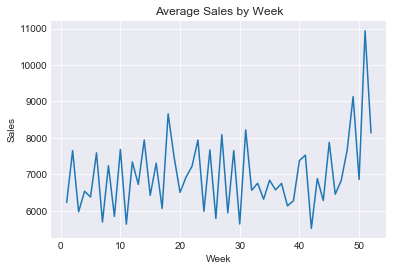

In [38]:
sales_per_week = df_open.groupby('Week')['Sales'].mean()
linePlot(sales_per_week, 'Week', 'Sales', 'Average Sales by Week')

#### More evidence for seasonality, increasing sales towards the end of the year.

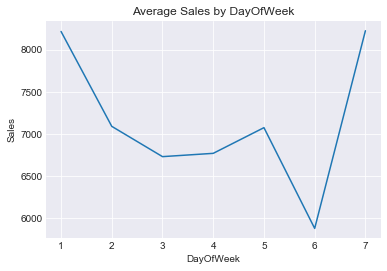

In [39]:
sales_per_weekday = df_open.groupby('DayOfWeek')['Sales'].mean()
linePlot(sales_per_weekday, 'DayOfWeek', 'Sales', 'Average Sales by DayOfWeek')

#### We've dropped the stores that are closed. The stores are usually closed on Sundays, but when they're open we see very high sales.

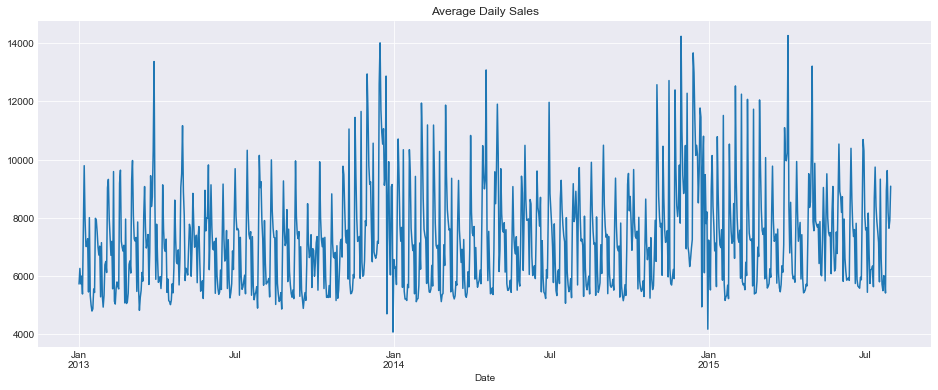

In [40]:
sales_per_date = df_open.groupby('Date')['Sales'].mean()
fig = plt.figure(figsize=(16, 6))
sales_per_date.plot(title='Average Daily Sales')

#### We see large spikes around Christmas time, right before the end of the year, but otherwise relatively consistent data over time

### Examine categorical features

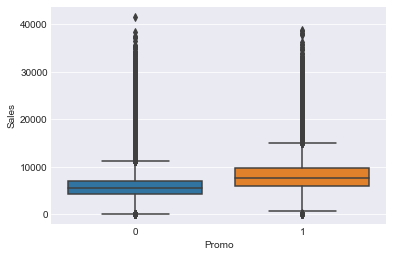

In [41]:
sns.boxplot(x='Promo', y='Sales', data=df_open)

#### Promo appears to have some effect when determining total sales.

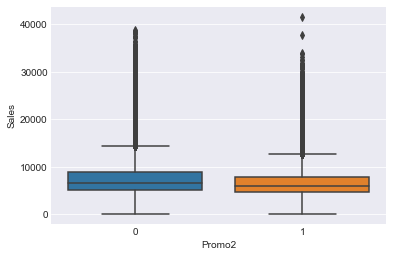

In [42]:
sns.boxplot(x='Promo2', y='Sales', data=df_open)

#### Promo 2 appears to have little effect.

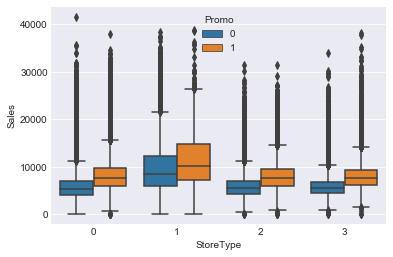

In [43]:
sns.boxplot(x='StoreType', y='Sales', data=df_open, hue='Promo')

#### StoreType certainly appears to have an effect on sales, with StoreType 1 demonstrating high variability but also higher average sales.

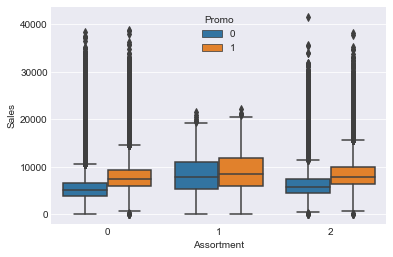

In [44]:
sns.boxplot(x='Assortment', y='Sales', data=df_open, hue='Promo')

#### Likewise with Assortment, also showing differing effects of Promo.

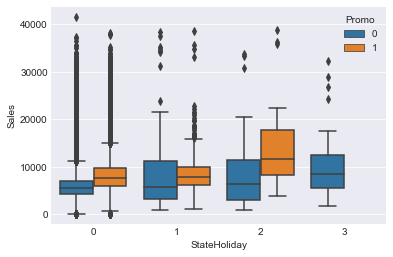

In [45]:
sns.boxplot(x='StateHoliday', y='Sales', data=df_open, hue='Promo')

#### When stores are open on a StateHoliday, high variability, likely due to fewer observations.

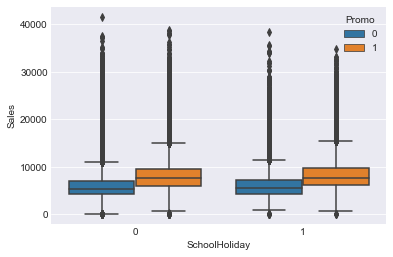

In [47]:
sns.boxplot(x='SchoolHoliday', y='Sales', data=df_open, hue='Promo')

#### Nearly identical sales based on SchoolHoliday.

### Correlations

In [83]:
# Examine the correlations between various features and 'Sales'
df_merged.corr()['Sales'].sort_values(ascending=False)

Sales                        1.000000
Customers                    0.894711
Open                         0.678472
Promo                        0.452345
SchoolHoliday                0.085124
Assortment                   0.074941
Week                         0.052946
Month                        0.048768
Year                         0.023519
CompetitionOpenSinceYear     0.010115
Store                        0.005126
Day                         -0.011612
StoreType                   -0.013057
CompetitionDistance         -0.018869
CompetitionOpenSinceMonth   -0.023638
Promo2                      -0.091040
StateHoliday                -0.229029
DayOfWeek                   -0.462125
Name: Sales, dtype: float64

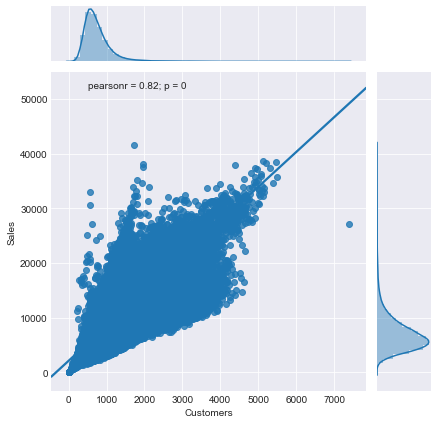

In [48]:
# Clearly a very high correlation between customers and sales
sns.jointplot(x='Customers', y='Sales', data=df_open, kind='reg')

#### Unfortunately we won't have customers available for the test set

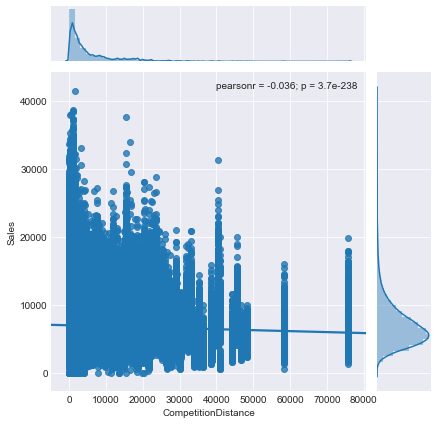

In [49]:
sns.jointplot(x='CompetitionDistance', y='Sales', data=df_open, kind='reg')

#### No correlation between CompetitionDistance and Sales.

### Autocorrelation

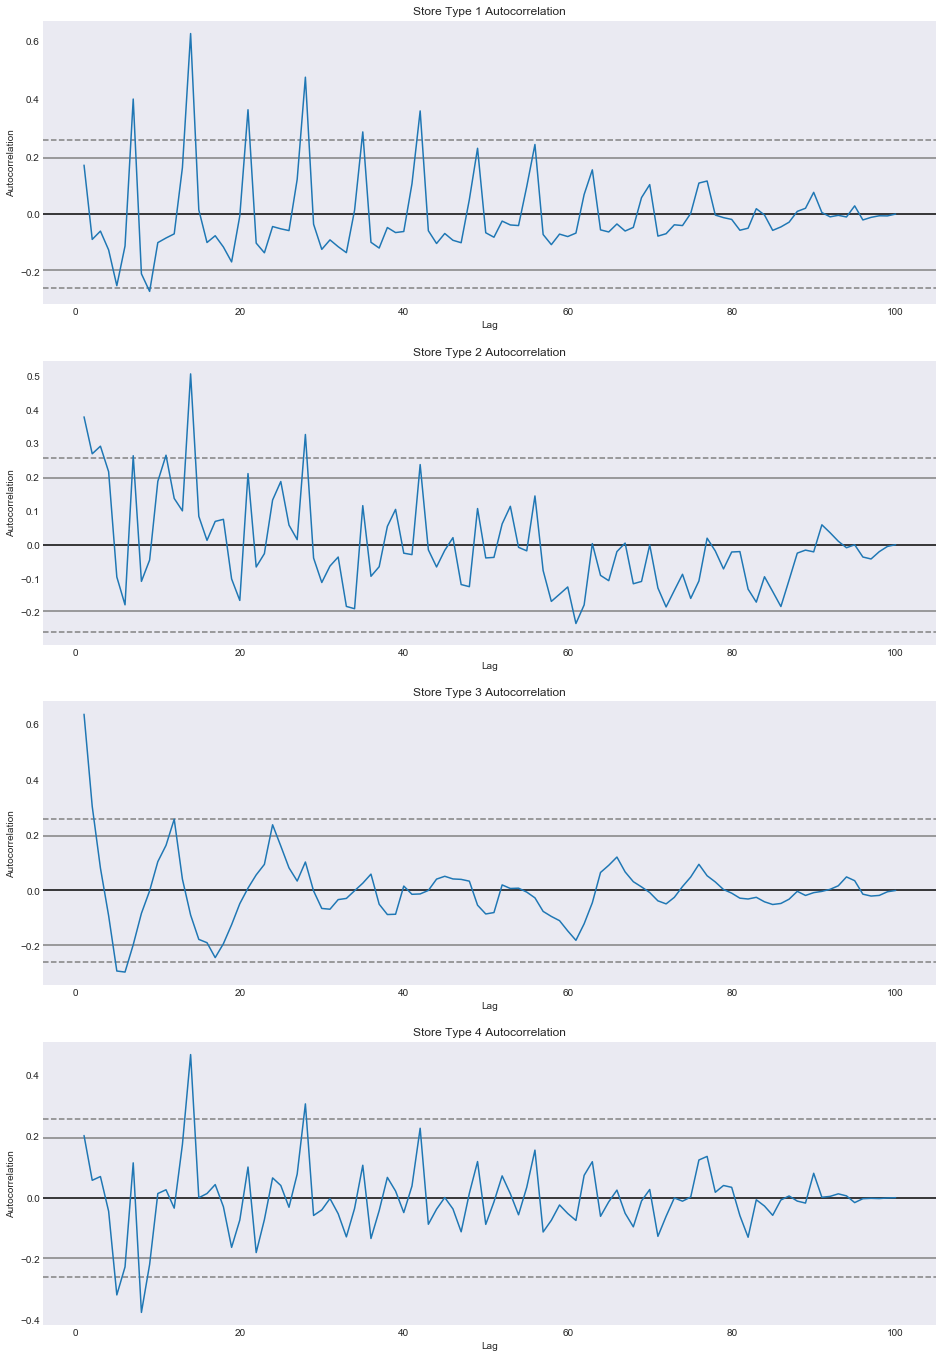

In [50]:
from pandas.plotting import autocorrelation_plot
df_by_store_type = df_open.groupby(['StoreType', 'Date'])['Sales'].mean()
fig = plt.figure(figsize=(16, 24))

for i in range(1, 5):
    ax = fig.add_subplot(4, 1, i)
    plt.title('Store Type ' +  str(i) + ' Autocorrelation')
    autocorrelation_plot(df_by_store_type[i - 1][:100], ax)

- With Store types 1 & 2, we see what appears to be a weekly pattern of spiking correlations. Sales on the same day from previous weeks appear to have an influence. 
- Store types 3 & 4 seem to have weaker correlations with past observations. 
- Although it's clear these data still aren't random, few autocorrelations count as statistically significant. 
- Store Types 2 & 3 demonstrate strong autocorrelations with previous day sales, but types 1 & 4 do not. 

## Building Models

In [33]:
# Create the train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_merged.drop(columns=['Sales', 'Customers', 'Date']),
                                                    df_merged['Sales'], test_size=0.10)

### Train a basic neural network model 

In [51]:
# 32 nodes in 1st hidden layer, 16 in 2nd hidden layer
model = Sequential()
model.add(Dense(32, input_dim=16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(1))
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
history = model.fit(X_train, y_train, 
                    batch_size=64,
                    epochs=20,
                    shuffle=True,
                    validation_data=[X_test, y_test])

Train on 915488 samples, validate on 101721 samples
Epoch 1/20
915488/915488 [==============================] - 66s 72us/step - loss: 13177457.8366 - mean_squared_error: 13177457.8366 - val_loss: 8845803.0411 - val_mean_squared_error: 8845803.0411
Epoch 2/20
915488/915488 [==============================] - 66s 72us/step - loss: 7843253.2921 - mean_squared_error: 7843253.2921 - val_loss: 7132465.5375 - val_mean_squared_error: 7132465.5375
Epoch 3/20
915488/915488 [==============================] - 66s 72us/step - loss: 6984989.9865 - mean_squared_error: 6984989.9865 - val_loss: 6746230.1816 - val_mean_squared_error: 6746230.1816
Epoch 4/20
915488/915488 [==============================] - 69s 75us/step - loss: 6760033.3586 - mean_squared_error: 6760033.3586 - val_loss: 6497289.5603 - val_mean_squared_error: 6497289.5603
Epoch 5/20
915488/915488 [==============================] - 74s 80us/step - loss: 6673712.0729 - mean_squared_error: 6673712.0729 - val_loss: 6498249.0053 - val_mean_squa

### Make Predictions

In [58]:
df_test_merged.sort_values(by=['Id'], inplace=True)
preds = model.predict(df_test_merged.drop(['Date', 'Id'], axis=1))
preds = np.rint(preds)

df_preds = pd.DataFrame(preds, columns=['Sales'])
df_preds.index += 1
df_preds.clip(lower=0, inplace=True)
df_preds.to_csv('basicNetSubmission.csv', index_label='Id')

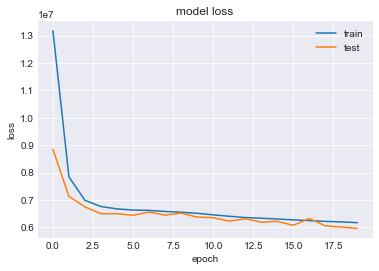

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### This submission results in a 0.44 score on the leaderboard, which is quite poor. But it's a very basic model, and standard neural nets don't seem to be very well-suited for a problem like this. This model does not show signs of overfitting, but due to time constraints I will not train further.

### Train Gradient-Boosted Trees

In [71]:
# Params taken from 
xgb = xgboost.XGBRegressor(max_depth=8, subsample=0.7, colsample_bytree=0.7, 
                           learning_rate=0.3, n_estimators=500)

In [72]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb.fit(X_train, y_train, eval_set=eval_set, eval_metric='rmse')

[0]	validation_0-rmse:5188.75	validation_1-rmse:5173.88
[1]	validation_0-rmse:4055.12	validation_1-rmse:4039.88
[2]	validation_0-rmse:3336.41	validation_1-rmse:3318.75
[3]	validation_0-rmse:2885.02	validation_1-rmse:2870.18
[4]	validation_0-rmse:2567.03	validation_1-rmse:2553.17
[5]	validation_0-rmse:2376.57	validation_1-rmse:2363.04
[6]	validation_0-rmse:2260.79	validation_1-rmse:2249.07
[7]	validation_0-rmse:2094.09	validation_1-rmse:2085.17
[8]	validation_0-rmse:1958.32	validation_1-rmse:1949.34
[9]	validation_0-rmse:1921.09	validation_1-rmse:1912.55
[10]	validation_0-rmse:1884.08	validation_1-rmse:1877.28
[11]	validation_0-rmse:1830.28	validation_1-rmse:1827.37
[12]	validation_0-rmse:1789.36	validation_1-rmse:1787.13
[13]	validation_0-rmse:1774.34	validation_1-rmse:1772.71
[14]	validation_0-rmse:1729.73	validation_1-rmse:1730.02
[15]	validation_0-rmse:1708.72	validation_1-rmse:1710.03
[16]	validation_0-rmse:1688.65	validation_1-rmse:1690.33
[17]	validation_0-rmse:1663.32	validation

[144]	validation_0-rmse:788.593	validation_1-rmse:821.309
[145]	validation_0-rmse:787.549	validation_1-rmse:820.484
[146]	validation_0-rmse:786.761	validation_1-rmse:819.895
[147]	validation_0-rmse:786.039	validation_1-rmse:819.435
[148]	validation_0-rmse:785.066	validation_1-rmse:818.648
[149]	validation_0-rmse:783.676	validation_1-rmse:817.543
[150]	validation_0-rmse:782.013	validation_1-rmse:816.129
[151]	validation_0-rmse:780.667	validation_1-rmse:815.151
[152]	validation_0-rmse:778.636	validation_1-rmse:813.221
[153]	validation_0-rmse:777.697	validation_1-rmse:812.264
[154]	validation_0-rmse:776.652	validation_1-rmse:811.577
[155]	validation_0-rmse:775.994	validation_1-rmse:811.025
[156]	validation_0-rmse:774.692	validation_1-rmse:810.026
[157]	validation_0-rmse:773.232	validation_1-rmse:808.846
[158]	validation_0-rmse:771.364	validation_1-rmse:807.267
[159]	validation_0-rmse:770.115	validation_1-rmse:806.319
[160]	validation_0-rmse:768.611	validation_1-rmse:804.932
[161]	validati

[286]	validation_0-rmse:670.987	validation_1-rmse:726.903
[287]	validation_0-rmse:670.466	validation_1-rmse:726.592
[288]	validation_0-rmse:670.04	validation_1-rmse:726.36
[289]	validation_0-rmse:669.458	validation_1-rmse:725.916
[290]	validation_0-rmse:668.957	validation_1-rmse:725.581
[291]	validation_0-rmse:668.482	validation_1-rmse:725.253
[292]	validation_0-rmse:668.028	validation_1-rmse:725.039
[293]	validation_0-rmse:667.527	validation_1-rmse:724.644
[294]	validation_0-rmse:667.295	validation_1-rmse:724.472
[295]	validation_0-rmse:666.613	validation_1-rmse:723.919
[296]	validation_0-rmse:666.007	validation_1-rmse:723.364
[297]	validation_0-rmse:665.099	validation_1-rmse:722.61
[298]	validation_0-rmse:664.358	validation_1-rmse:722.197
[299]	validation_0-rmse:663.415	validation_1-rmse:721.055
[300]	validation_0-rmse:663.131	validation_1-rmse:721.002
[301]	validation_0-rmse:662.394	validation_1-rmse:720.424
[302]	validation_0-rmse:661.922	validation_1-rmse:720.168
[303]	validation_

[428]	validation_0-rmse:612.268	validation_1-rmse:687.607
[429]	validation_0-rmse:611.675	validation_1-rmse:687.264
[430]	validation_0-rmse:611.44	validation_1-rmse:687.101
[431]	validation_0-rmse:611.127	validation_1-rmse:686.894
[432]	validation_0-rmse:610.711	validation_1-rmse:686.662
[433]	validation_0-rmse:610.288	validation_1-rmse:686.342
[434]	validation_0-rmse:609.606	validation_1-rmse:685.792
[435]	validation_0-rmse:609.384	validation_1-rmse:685.631
[436]	validation_0-rmse:609.061	validation_1-rmse:685.495
[437]	validation_0-rmse:608.822	validation_1-rmse:685.352
[438]	validation_0-rmse:608.347	validation_1-rmse:685.082
[439]	validation_0-rmse:608.138	validation_1-rmse:685.016
[440]	validation_0-rmse:607.891	validation_1-rmse:684.875
[441]	validation_0-rmse:607.735	validation_1-rmse:684.763
[442]	validation_0-rmse:607.537	validation_1-rmse:684.636
[443]	validation_0-rmse:607.229	validation_1-rmse:684.5
[444]	validation_0-rmse:606.89	validation_1-rmse:684.363
[445]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

### Make Predictions

In [73]:
df_test_merged.sort_values(by=['Id'], inplace=True)
xgb_preds = xgb.predict(df_test_merged.drop(['Date', 'Id'], axis=1))
xgb_preds = np.rint(xgb_preds)

df_preds = pd.DataFrame(xgb_preds, columns=['Sales'])
df_preds.index += 1
df_preds.clip(lower=0, inplace=True)
df_preds.to_csv('xgbSubmission.csv', index_label='Id')

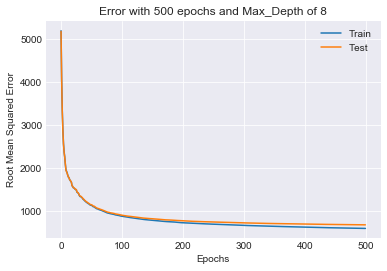

In [74]:
results = xgb.evals_result()

fig, ax = plt.subplots()
ax.plot(range(0, 500), results['validation_0']['rmse'], label='Train')
ax.plot(range(0, 500), results['validation_1']['rmse'], label='Test')
ax.legend()

plt.ylabel('Root Mean Squared Error')
plt.xlabel('Epochs')
plt.title('Error with 500 epochs and Max_Depth of 8')
plt.show()

#### Looks like we can be more aggressive with epochs and likely Max_Depth as well. This model performed very well and earned a score of .12125 on the public Leaderboard (top third)!

### Train Second Gradient-Boosted Tree Model

In [75]:
xgb2 = xgboost.XGBRegressor(max_depth=10, subsample=0.7, colsample_bytree=0.7, 
                           learning_rate=0.3, n_estimators=600)

In [76]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb2.fit(X_train, y_train, eval_set=eval_set, eval_metric='rmse')

[0]	validation_0-rmse:5146.91	validation_1-rmse:5132.18
[1]	validation_0-rmse:3979.89	validation_1-rmse:3965.37
[2]	validation_0-rmse:3231.09	validation_1-rmse:3215.02
[3]	validation_0-rmse:2745.15	validation_1-rmse:2731.58
[4]	validation_0-rmse:2404.69	validation_1-rmse:2395.53
[5]	validation_0-rmse:2182.96	validation_1-rmse:2175.68
[6]	validation_0-rmse:2045.65	validation_1-rmse:2042.36
[7]	validation_0-rmse:1853.69	validation_1-rmse:1854.71
[8]	validation_0-rmse:1759.55	validation_1-rmse:1765.12
[9]	validation_0-rmse:1717.56	validation_1-rmse:1724.24
[10]	validation_0-rmse:1683.52	validation_1-rmse:1690.84
[11]	validation_0-rmse:1611.12	validation_1-rmse:1619.97
[12]	validation_0-rmse:1553.07	validation_1-rmse:1563.61
[13]	validation_0-rmse:1529.57	validation_1-rmse:1540.73
[14]	validation_0-rmse:1511.93	validation_1-rmse:1523.97
[15]	validation_0-rmse:1496.6	validation_1-rmse:1510.84
[16]	validation_0-rmse:1438.43	validation_1-rmse:1454.09
[17]	validation_0-rmse:1420.42	validation_

[144]	validation_0-rmse:633.541	validation_1-rmse:716.508
[145]	validation_0-rmse:632.361	validation_1-rmse:715.653
[146]	validation_0-rmse:631.208	validation_1-rmse:715.361
[147]	validation_0-rmse:630.287	validation_1-rmse:714.913
[148]	validation_0-rmse:629.405	validation_1-rmse:714.445
[149]	validation_0-rmse:628.343	validation_1-rmse:713.75
[150]	validation_0-rmse:627.239	validation_1-rmse:713.356
[151]	validation_0-rmse:626.055	validation_1-rmse:712.652
[152]	validation_0-rmse:624.206	validation_1-rmse:711.126
[153]	validation_0-rmse:623.438	validation_1-rmse:710.85
[154]	validation_0-rmse:622.497	validation_1-rmse:710.35
[155]	validation_0-rmse:621.223	validation_1-rmse:709.763
[156]	validation_0-rmse:619.95	validation_1-rmse:708.861
[157]	validation_0-rmse:618.544	validation_1-rmse:707.939
[158]	validation_0-rmse:617.327	validation_1-rmse:707.232
[159]	validation_0-rmse:616.48	validation_1-rmse:706.771
[160]	validation_0-rmse:614.715	validation_1-rmse:705.283
[161]	validation_0-

[286]	validation_0-rmse:524.821	validation_1-rmse:665.705
[287]	validation_0-rmse:524.443	validation_1-rmse:665.607
[288]	validation_0-rmse:524.074	validation_1-rmse:665.435
[289]	validation_0-rmse:523.523	validation_1-rmse:665.198
[290]	validation_0-rmse:523.058	validation_1-rmse:665.069
[291]	validation_0-rmse:522.37	validation_1-rmse:664.946
[292]	validation_0-rmse:521.808	validation_1-rmse:664.705
[293]	validation_0-rmse:521.252	validation_1-rmse:664.407
[294]	validation_0-rmse:521.006	validation_1-rmse:664.216
[295]	validation_0-rmse:520.632	validation_1-rmse:664.08
[296]	validation_0-rmse:520.242	validation_1-rmse:664.087
[297]	validation_0-rmse:519.664	validation_1-rmse:664.021
[298]	validation_0-rmse:519.236	validation_1-rmse:663.856
[299]	validation_0-rmse:518.691	validation_1-rmse:663.73
[300]	validation_0-rmse:518.237	validation_1-rmse:663.654
[301]	validation_0-rmse:517.619	validation_1-rmse:663.372
[302]	validation_0-rmse:517.101	validation_1-rmse:663.164
[303]	validation_

[428]	validation_0-rmse:470.262	validation_1-rmse:649.893
[429]	validation_0-rmse:469.936	validation_1-rmse:649.81
[430]	validation_0-rmse:469.584	validation_1-rmse:649.78
[431]	validation_0-rmse:469.277	validation_1-rmse:649.578
[432]	validation_0-rmse:468.771	validation_1-rmse:649.402
[433]	validation_0-rmse:468.426	validation_1-rmse:649.38
[434]	validation_0-rmse:468.094	validation_1-rmse:649.279
[435]	validation_0-rmse:467.732	validation_1-rmse:649.222
[436]	validation_0-rmse:467.42	validation_1-rmse:649.273
[437]	validation_0-rmse:467.139	validation_1-rmse:649.286
[438]	validation_0-rmse:466.97	validation_1-rmse:649.303
[439]	validation_0-rmse:466.698	validation_1-rmse:649.366
[440]	validation_0-rmse:466.38	validation_1-rmse:649.082
[441]	validation_0-rmse:466.154	validation_1-rmse:649.08
[442]	validation_0-rmse:465.92	validation_1-rmse:649.025
[443]	validation_0-rmse:465.543	validation_1-rmse:648.873
[444]	validation_0-rmse:465.074	validation_1-rmse:648.9
[445]	validation_0-rmse:

[571]	validation_0-rmse:431.021	validation_1-rmse:642.257
[572]	validation_0-rmse:430.878	validation_1-rmse:642.215
[573]	validation_0-rmse:430.677	validation_1-rmse:642.166
[574]	validation_0-rmse:430.543	validation_1-rmse:642.171
[575]	validation_0-rmse:430.339	validation_1-rmse:642.213
[576]	validation_0-rmse:430.087	validation_1-rmse:642.154
[577]	validation_0-rmse:429.831	validation_1-rmse:642.034
[578]	validation_0-rmse:429.671	validation_1-rmse:642.016
[579]	validation_0-rmse:429.441	validation_1-rmse:641.984
[580]	validation_0-rmse:429.212	validation_1-rmse:642.005
[581]	validation_0-rmse:428.979	validation_1-rmse:642.025
[582]	validation_0-rmse:428.792	validation_1-rmse:642.005
[583]	validation_0-rmse:428.582	validation_1-rmse:642.013
[584]	validation_0-rmse:428.419	validation_1-rmse:642.016
[585]	validation_0-rmse:428.25	validation_1-rmse:641.95
[586]	validation_0-rmse:428.051	validation_1-rmse:641.946
[587]	validation_0-rmse:427.789	validation_1-rmse:641.97
[588]	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

### Make Predictions

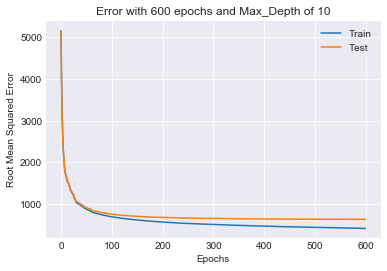

In [77]:
results = xgb2.evals_result()

fig, ax = plt.subplots()
ax.plot(range(0, 600), results['validation_0']['rmse'], label='Train')
ax.plot(range(0, 600), results['validation_1']['rmse'], label='Test')
ax.legend()

plt.ylabel('Root Mean Squared Error')
plt.xlabel('Epochs')
plt.title('Error with 600 epochs and Max_Depth of 10')
plt.show()

#### This model looks like it's starting to overfit. It also earned a score of .12502 on the Kaggle leaderboard, which confirms my suspicions.

In [78]:
df_test_merged.sort_values(by=['Id'], inplace=True)
xgb_preds = xgb2.predict(df_test_merged.drop(['Date', 'Id'], axis=1))
xgb_preds = np.rint(xgb_preds)

df_preds = pd.DataFrame(xgb_preds, columns=['Sales'])
df_preds.index += 1
df_preds.clip(lower=0, inplace=True)
df_preds.to_csv('xgbSubmission.csv', index_label='Id')

## Conclusion/Future Work
- Given more time, I would have liked to analyze the time series in greater depth. We could have used ARIMA or Facebook Prophet for forecasting. 
    - Based on the autocorrelation plots, however, we see relatively small correlations for the lagged time steps.
- Despite that, using XGBoost to construct Gradient-Boosted Trees gives fantastic performance: based on the Kaggle leaderboard it's the model of choice.
- Another possibility: use a LSTM or GRU Recurrent Network to model the time series and forecast the next 6 weeks. This would likely perform better than the basic neural network model.
    - Caveat: We would need to tune sequence size based on StoreType, as we saw with the Autocorrelation plots.
- Use the features from Store that we discarded which were related to Promo2.
    - Caveat: Promo2 appeared to have little correlation with Sales.
- Ultimately: Gradient-Boosted Trees were quite powerful, and gave me a best RMSPE of .12125, good enough for top third on the leaderboard.